In [68]:
import sys
import gsw
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [69]:
sys.path.append('..')
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
matplotlib.rc_file('../rc_file')
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
from maps import rect_polygon
from paths import file_ex_ocn_ctrl, path_results, path_prace
from filters import lowpass
from regions import SST_index_bounds
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import LogFormatter, ScalarFormatter


## Data

In [41]:
# 1.1  climate history time series from different publications
zachos = pd.read_fwf('../../data/Zachos/zachos2001.txt', widths=[9,17,15,11,11,13,16],  header=88)
west = pd.read_csv('../../data/Westerhold2020/TableS34.tab', header=22, delimiter='\t')
epic = pd.read_csv('../../data/EPICA/edc3deuttemp2007.txt', header=69, sep='\s+')
epica = pd.read_excel('../../data/EPICA/41586_2004_BFnature02599_MOESM7_ESM.xls')
had = xr.open_dataarray('../../data/HadCRUT/ihadcrut5_global.nc', decode_times=False)
p2k = pd.read_csv('../../data/PAGES2K/Full_ensemble_median_and 95pct_range.txt', header=4, sep='\t')

# https://en.wikipedia.org/wiki/List_of_Quaternary_volcanic_eruptions
volcanoes = [1991,1912,1902,1883,1815,1808,1783,1660,1650,1600,1580,1477,1280,1257,\
             946,934,930,800,710,700,540,431,240,230,60,50]

# 1.2  GLORYS renanalysis for eddy map and zonal wind profile
# zonal wind data downloaded from ERA5 servers: 1990-2019 10 meter u-velocity:
glorys = xr.open_dataset('../../data/GLORYS/global-reanalysis-phy-001-030-daily_1629665187220.nc')
u = xr.open_dataarray(f'{path_prace}/ERA5/adaptor.mars.internal-1624788162.5833714-12833-1-d955db15-d94e-45a1-91e6-2709187ebfc6.nc')
u = u.mean(['time','longitude'])

# 1.3  GODAS reanalysis for AMOC plot
T = xr.open_dataset(f'{path_prace}/GODAS/pottmp.2020.nc').mean('time')
S = xr.open_dataset(f'{path_prace}/GODAS/salt.2020.nc').mean('time')
HF = xr.open_dataset(f'{path_prace}/GODAS/thflx.2020.nc').mean('time')
SF = xr.open_dataset(f'{path_prace}/GODAS/sltfl.2020.nc').mean('time')
CT = xr.apply_ufunc(gsw.conversions.CT_from_pt, 1000*S.salt, T.pottmp-273.15, dask='parallelized')
sigma0 = xr.apply_ufunc(gsw.density.sigma0, 1000*S.salt, CT, dask='parallelized')

## Fig 1.1 Climate variability

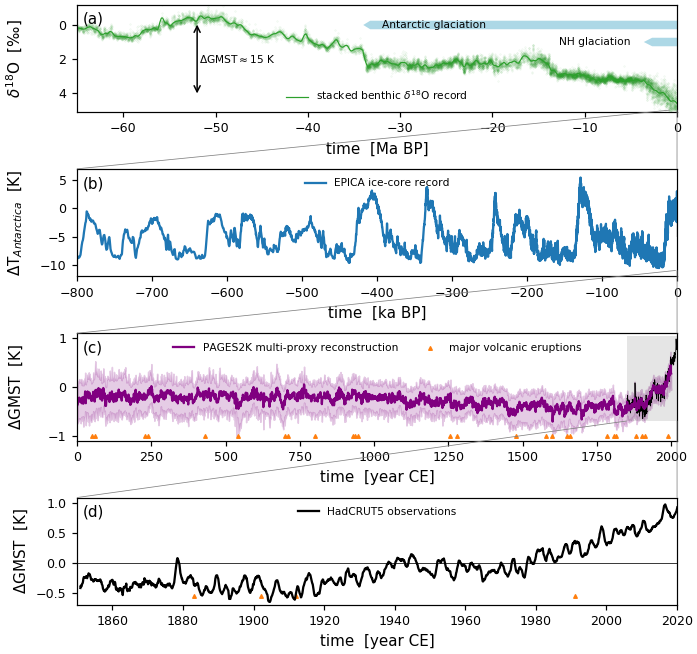

In [65]:
f, ax = plt.subplots(4,1, figsize=(6.4,6), constrained_layout=True)

# ax[0].scatter(-zachos['Age_(Ma)'], zachos['d18O_adj.*'], s=.2, alpha=.1, color='C2')
ax[0].scatter(-west['Tuned time [Ma]'], west['Foram bent δ18O [‰ PDB] (ISOBENbinned_d18O)'], s=.1, alpha=.1, c='C2')
# ax[0].plot(-zachos['Age_(Ma)'], zachos['d18O_adj.*'].rolling(5).mean(), label=r'stacked benthic $\delta^{18}$O record', lw=.8, c='C2')
ax[0].plot(-west['Tuned time [Ma]'], west['Foram bent δ18O [‰ PDB] (ISOBENd18oLOESSsmoothLongTerm)'], label=r'stacked benthic $\delta^{18}$O record', lw=.8, c='C2')
# ax[0].plot(-west['Tuned time [Ma]'], west['Foram bent δ18O [‰ PDB] (ISOBENd18oLOESSsmooth)'], c='C3', lw=.5)
ax[0].arrow(x=0, y=0 , dx=-34 , dy=0, width=.5, head_width=.5, length_includes_head=True, fc='lightblue',linewidth=0)
ax[0].arrow(x=0, y=1, dx=-3.6, dy=0, width=.5, head_width=.5, head_length=0.9, length_includes_head=True, fc='lightblue', linewidth=0)
ax[0].text(-32,0, 'Antarctic glaciation', ha='left', va='center', fontsize=7)
ax[0].text(-5,1, 'NH glaciation', ha='right', va='center', fontsize=7)
ax[0].invert_yaxis()
ax[0].annotate(s='', xy=(-52,4.2), xytext=(-52,-0.2), arrowprops=dict(arrowstyle='<->'))
ax[0].text(-51.8,2, r'$\Delta$GMST$\approx$15 K', va='center', fontsize=7)

ax[1].plot(-epic['Age']/1e3, epic['Temperature'], label='EPICA ice-core record')

ax[2].plot(had.time/12+1850, had.rolling(time=12).mean(), c='k', lw=.5)
ax[2].fill_between(p2k['Year'], p2k['Full ensemble 2.5th percentile'], p2k['Full ensemble 97.5th percentile'], color='purple', edgecolor=None, alpha=.2)
ax[2].plot(p2k['Year'], p2k['Full ensemble median'], c='purple', label='PAGES2K multi-proxy reconstruction')
ax[2].scatter(volcanoes, len(volcanoes)*[-1], marker='^', s=5, color='C1', label='major volcanic eruptions')

ax[3].axhline(0, c='k', lw=.5)
ax[3].plot(had.time/12+1850, had.rolling(time=12).mean(), label='HadCRUT5 observations', c='k')
ax[3].scatter(volcanoes, len(volcanoes)*[-.55], marker='^', s=5, color='C1')

for yr in [-800,0]:
    con = ConnectionPatch(xyA=(yr,7), xyB=((yr)/1e3,5), coordsA="data", coordsB="data",
                          axesA=ax[1], axesB=ax[0], color="grey", linewidth=.5)
    f.add_artist(con)

rect = plt.Rectangle((-1.95, -5), width=2, height=8, facecolor="black", alpha=0.1)
ax[1].add_patch(rect)
for yr in [0,2020]:
    con = ConnectionPatch(xyA=(yr,1.1), xyB=((yr-1950)/1e3,-11), coordsA="data", coordsB="data",
                          axesA=ax[2], axesB=ax[1], color="grey", linewidth=.5)
    f.add_artist(con)

rect = plt.Rectangle((1850, -.7), width=170, height=1.75, facecolor="black", alpha=0.1)
ax[2].add_patch(rect)
for yr in [1850,2020]:
    #https://stackoverflow.com/questions/17543359/drawing-lines-between-two-plots-in-matplotlib
    con = ConnectionPatch(xyA=(yr,1.1), xyB=(yr,-.7), coordsA="data", coordsB="data",
                          axesA=ax[3], axesB=ax[2], color="grey", linewidth=.5)
    f.add_artist(con)

ax[0].set_ylim((5.1,-1.2))
ax[1].set_ylim((-12,7))
ax[2].set_ylim((-1.1,1.1))
ax[3].set_ylim((-.7,1.1))

ax[0].set_xlim((-65,70/1e6))
ax[1].set_xlim((-800,0.07))
ax[2].set_xlim((0,2020))
ax[3].set_xlim((1850,2020))

ax[0].set_ylabel(r'$\delta^{18}$O  [‰]')
ax[1].set_ylabel(r'$\Delta$T$_{Antarctica}$  [K]')
ax[2].set_ylabel(r'$\Delta$GMST  [K]')
ax[3].set_ylabel(r'$\Delta$GMST  [K]')

for i in range(4):
    ax[i].text(0.01,.82,'('+'abcd'[i]+')', transform=ax[i].transAxes)
    ax[i].legend(fontsize=7, ncol=2, loc=['lower','upper','upper','upper'][i]+' center', frameon=False)
    ax[i].set_xlabel('time  ['+['Ma BP','ka BP','year CE','year CE'][i]+']')

f.align_ylabels()
f.savefig('../../results/thesis/11_timeseries')

## Fig 1.2 Wind driven circulation

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


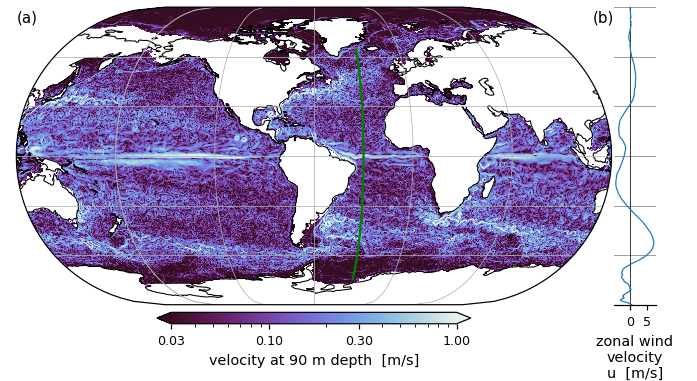

In [25]:
f = plt.figure(figsize=(6.4,3.5))

ax = f.add_axes([0,.2,.9,.78], projection=ccrs.EckertIII(central_longitude=-60))
ax.text(0,.95,'(a)', transform=ax.transAxes)
im = ax.pcolormesh(glorys.longitude, glorys.latitude, np.sqrt(glorys.uo.squeeze()**2+glorys.vo.squeeze()**2),
                   norm=colors.LogNorm(vmin=0.03, vmax=1),
                   cmap='cmo.dense_r', transform=ccrs.PlateCarree())
ax.plot(101*[-30], np.linspace(-74.5,64.5,101), c='green', transform=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=.7)
ax.gridlines(linewidth=.5)
ax.set_global()

cbax = f.add_axes([0.225,.15,.45,.03])
# formatter = LogFormatter(10, labelOnlyBase=False) 
formatter = ScalarFormatter()
formatter.set_scientific(False)
cb = plt.colorbar(im, cax=cbax, ticks=[0.03,.1,.3,1], orientation='horizontal', extend='both', format=formatter)
cb.set_label(label='velocity at 90 m depth  [m/s]', size=9.5)
# plt.colorbar(im, cax=cbax, ticks=[0.01,0.03,.1,.3,1], orientation='horizontal', extend='both', format=formatter).set_label(label='velocity at 90 m depth  [m/s]', size=9.5)
# cb.set_major_formatter(formatter)

ax = f.add_axes([.88,.2,.06,.78])
ax.text(0,.95,'(b)', transform=ax.transAxes, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_yticks([])
ax.set_xlabel('zonal wind\nvelocity\nu  [m/s]', fontsize=9.5)
for l in np.arange(-90,91,30):
    ax.axhline(l, c='grey', lw=.5)
ax.set_ylim((-90,90))
ax.axvline(0, c='k', lw=.5)
ax.plot(u, u.latitude, lw=.8)

plt.savefig('../../results/thesis/12_circulation', dpi=600)

I added the arrows with Inkscape.

## Fig 1.3 Overturning circulation

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


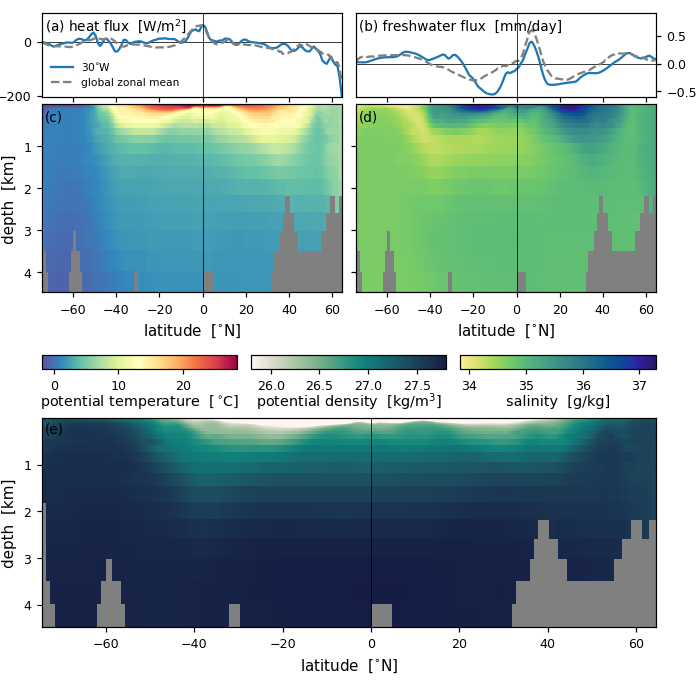

In [522]:
def section(da, which={'lon':330}):
    """ returns time mean"""
    return da.sel(**which, method='nearest')

f= plt.figure(figsize=(6.4,6.4))
    
cbkw = dict(orientation='horizontal', pad=0.1)
x = T.lat
    
# temperature
ax1 = f.add_axes([.06 ,.86,.43,.12])
ax2 = f.add_axes([.51,.86,.43,.12])
ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xticklabels([])
    ax.set_xlim((x.min(),x.max()))

axa = f.add_axes([.06 ,.47 ,.28,.02])
axb = f.add_axes([.36 ,.47 ,.28,.02])
axc = f.add_axes([.66 ,.47 ,.28,.02])

axt = f.add_axes([.06 ,.58,.43,.27 ])
axs = f.add_axes([.51,.58,.43,.27 ])
axd = f.add_axes([.06 ,.1 ,.88,.3 ])
for ax in [axt, axs, axd]:
    ax.set_facecolor('grey')
    ax.invert_yaxis()
    ax.set_xlabel(r'latitude  [$\!^\circ\!$N]')
axt.set_ylabel('depth  [km]')
axd.set_ylabel('depth  [km]')

# heat flux
ax1.axhline(0, c='k', lw=.5)
ax1.plot(x, HF.thflx.sel(lon=330, method='nearest'), label=r'30$\!^\circ\!$W')
ax1.plot(x, HF.thflx.mean('lon'), ls='--', c='grey', label='global zonal mean')
ax1.legend(fontsize=7, frameon=False)
ax1.set_ylim((-205,105))

# FW flux
fwf = -86400*1000/35
ax2.axhline(0, c='k', lw=.5)
ax2.plot(x, fwf*SF.sltfl.sel(lon=330, method='nearest'))
ax2.plot(x, fwf*SF.sltfl.mean('lon'), ls='--', c='grey')
ax2.set_ylim((-.6,.9))

# temperature
im = axt.pcolormesh(x, T.level/1e3, section(T.pottmp)-273.15, cmap='Spectral_r')
plt.colorbar(im, cax=axa, **cbkw)
axa.text(.5,-2.3,'potential temperature  [$^\circ\!$C]', transform=axa.transAxes, ha='center', va='center', size=9.5)

# salinity
axs.set_yticklabels([])
im = axs.pcolormesh(x, S.level/1e3, 1000*section(S.salt), cmap='cmo.haline_r')
plt.colorbar(im, cax=axc, **cbkw)
axc.text(.5,-2.3,'salinity  [g/kg]', transform=axc.transAxes, ha='center', va='center', size=9.5)
# density
im = axd.pcolormesh(x, sigma0.level/1e3, section(sigma0), vmin=25.8, cmap='cmo.tempo')
# axd.contour(x, sigma0.level, section(sigma0), levels=[27.5,27.55,27.6,27.65,27.7,27.75,27.8,])
plt.colorbar(im, cax=axb, **cbkw)
axb.text(.5,-2.3,r'potential density  [kg/m$^3$]',transform=axb.transAxes, ha='center', va='center', size=9.5)

ax1.text(0.01,.8,r'(a) heat flux  [W/m$^2$]'     , transform=ax1.transAxes, size=9)
ax2.text(0.01,.8,r'(b) freshwater flux  [mm/day]', transform=ax2.transAxes, size=9)
for i, ax in enumerate([axt,axs, axd]):
    ax.text([.01,.01,.005][i],[.91,.91,.93][i],'('+['c','d','e'][i]+')', transform=ax.transAxes, size=9)
    
for ax in [ax1, ax2, axt, axs, axd]:
    ax.axvline(0,c='k', lw=.5)
f.savefig('../../results/thesis/13_overturning')

## 1.4 Anna's Variability Spectrum plot
## 1.5 Modes of Multidecadal Variability

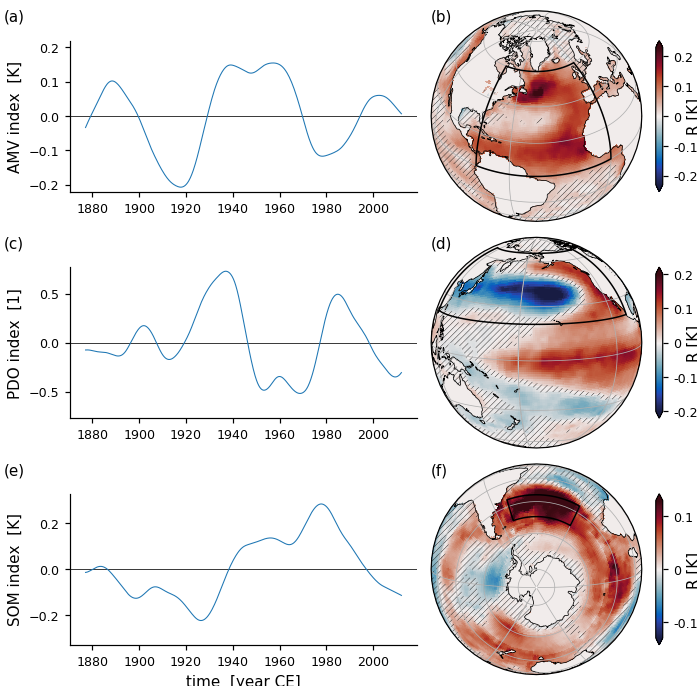

In [368]:
matplotlib.rcParams['hatch.linewidth'] = 0.25
ticks = [-.3,-.2,-.1,0,.1,.2,.3]
f = plt.figure(figsize=(6.4,3*2.1))
ax0, ax1 = [], []
for i, idx in enumerate(['AMV','PDO','SOM']):
    if idx=='AMV':
        xa = xr.open_dataset(f'{path_prace}/SST/AMO_regr_had.nc')
        da = xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_had.nc', **dc)
        std = lowpass(xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_had.nc'), 12*13).std().values
    elif idx=='PDO':
        xa = xr.open_dataset(f'{path_prace}/SST/PMV_20N_regr_had.nc')
        da = xr.open_dataset(f'{path_prace}/SST/PMV_EOF_20N_had.nc', **dc).pcs.isel(mode=0).squeeze()
        std = lowpass(xr.open_dataset(f'{path_prace}/SST/PMV_EOF_20N_had.nc').pcs.isel(mode=0), 12*13).std().values
    elif idx=='SOM':
        xa = xr.open_dataset(f'{path_prace}/SST/SOM_regr_had.nc')
        da = xr.open_dataarray(f'{path_prace}/SST/SOM_ds_dt_raw_had.nc', **dc)
        std = lowpass(xr.open_dataarray(f'{path_prace}/SST/SOM_ds_dt_raw_had.nc'), 12*13).std().values
        
    # patterns
    lats, lons = xa.latitude, xa.longitude
    lons, lats = np.meshgrid(lons, lats)
    clon, clat = [(-45,35),(190,10),(-30,-80)][i]
    maxv = [.23, .2, .13][i]
    ax = f.add_axes([1/1.618,1-.33*(i+1),1-1/1.618-.08,.32], projection=ccrs.Orthographic(central_longitude=clon, central_latitude=clat))
    ax.text(-2.03,.95,'('+['a','c','e'][i]+')', transform=ax.transAxes)
    ax.text(0,.95,'('+['b','d','f'][i]+')', transform=ax.transAxes)
    im = ax.pcolormesh(lons, lats, xa.slope*std, cmap='cmo.balance',
                           vmin=-maxv, vmax=maxv, transform=ccrs.PlateCarree())
    
    # hatching
    pvalue = xr.where(np.isfinite(xa.pval),xa.pval,0)
#     ax.contourf(lons, lats, pvalue, [0,0.05,1],
#                 colors='none', hatches=[None,'//////'], transform=ccrs.PlateCarree())
    ax.contourf(lons, lats, pvalue, [0,0.025,0.975,1],
            colors='none', hatches=[None,'//////',None], transform=ccrs.PlateCarree())
    
    ax.coastlines(resolution='110m', linewidth=.5)
    ax.gridlines(linewidth=.5)
    
    # recangles
    rect = [rect_polygon(SST_index_bounds('AMO')), 
             rect_polygon(SST_index_bounds('PDO')),
             rect_polygon(SST_index_bounds('SOM'))
            ][i]
    ax.add_patch(matplotlib.patches.Polygon(xy=rect,
                                          facecolor='none', edgecolor='k',
                                          linewidth=1, zorder=3,
                                          transform=ccrs.PlateCarree(), ), )
    
    ax0.append(ax)

    ax = f.add_axes([.94,1-.33*(i+1)+.05,.01,.22])
    cbar = plt.colorbar(im, cax=ax, shrink=.9, pad=.0, orientation='vertical', extend='both', ticks=ticks)
    cbar.ax.set_yticklabels(ticks)
    f.text(.985,1-.33*(i+1)+.16, 'R [K]', va='center', rotation=90)
    
    # timeseries
    maxv = [.22,.77,.33][i]
    
    ax = f.add_axes([0.1,1-.33*(i+1)+.05,1/1.618-.12,.22])
    ax.axhline(0, c='k', lw=.5)
    ax.plot(da.time[7*12:-7*12]/[365,365,365][i]+1870,
                lowpass(da, 12*13)[7*12:-7*12], lw=.7)
    ax.set_ylabel(idx+' index  ['+['K','1','K'][i]+']')
    ax.set_ylim((-maxv,maxv))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax1.append(ax)
ax1[-1].set_xlabel('time  [year CE]')
f.savefig('../../results/thesis/15_modes', dpi=600)

## 1.6 Conceptual ECS

-1.177826150712631 3.361079071356843
-0.7195344060390718 2.3965496190102575


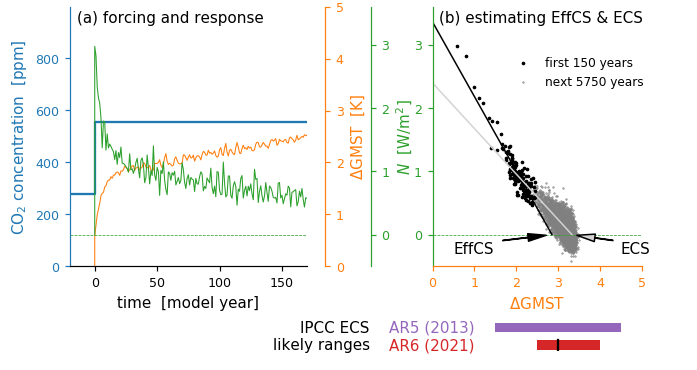

In [367]:
f = plt.figure(figsize=(6.4,3.4))

axl = f.add_axes([.10,.28,.34,.7])
axr = f.add_axes([.62,.28,.3,.7])
axb = f.add_axes([.62,.05,.3,.08])
ax1 = axl.twinx()
ax2 = axl.twinx()

# axl.set_title('(a)   forcing and response'          , fontsize=8, loc='left')
# axr.set_title('(b)   estimating climate sensitivity', fontsize=8, loc='left')
axl.text(.03,.94, '(a) forcing and response', transform=axl.transAxes)
axr.text(.03,.94, '(b) estimating EffCS & ECS', transform=axr.transAxes)
axl.set_xlabel('time  [model year]')
axr.set_xlabel(r'$\Delta$GMST', color='C1')

axl.set_ylabel(r'CO$_2$ concentration  [ppm]', color='C0')
ax1.set_ylabel(r'$\Delta$GMST  [K]', color='C1')
ax2.set_ylabel(r'$N$  [W/m$^2$]', color='C2')
ax2.axhline(0, c='C2', lw=.5, ls='--')
axr.axhline(0, c='C2', lw=.5, ls='--')

for ax in [axl,axr]:
    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

for ax in [ax1,ax2,axb]:
    for spine in ['top','left','bottom']:
        ax.spines[spine].set_visible(False)
axb.spines['right'].set_visible(False)

ax1.spines['right'].set_position(('outward', 12))
ax2.spines['right'].set_position(('outward', 42))

axl.spines['left'].set_color('C0')
ax1.spines['right'].set_color('C1')
axr.spines['bottom'].set_color('C1')
ax2.spines['right'].set_color('C2')
axr.spines['left'].set_color('C2')
axl.tick_params(axis='y', colors='C0')
axr.tick_params(axis='y', colors='C2')
axr.tick_params(axis='x', colors='C1')
ax1.tick_params(axis='y', colors='C1')
ax2.tick_params(axis='y', colors='C2')

# plot data
ax1.plot(np.insert(dmq.time.values,0,0), np.insert(dmq.T.values/2,0,0), c='C1', lw=.7)
ax2.plot(np.insert(dmq.time,0,0), np.insert(dmq.N/2,0,0), c='C2', lw=.7)
s1 = axr.scatter(dmq['T']/2, dmq['N']/2, color='grey', s=.2, label='next 5750 years')
s2 = axr.scatter(dmq['T'][:150]/2, dmq['N'][:150]/2, color='black', s=2, label='first 150 years')
axr.legend(handles=[s2,s1], loc=(.35,2/3), frameon=False, fontsize=8)
axl.plot([-20,0,0,170],[278,278,2*278,2*278], c='C0')

# Gregory fit
m, b = np.polyfit(dmq['T'][:150]/2, dmq['N'][:150]/2, 1)
print(m,b)
axr.plot([0,-b/m], [b,0], c='k', lw=1)
axr.annotate('EffCS', xy=[-b/m,0], xytext=[.5,-.3], arrowprops=dict(facecolor='black', shrink=0.1, width=.2, headwidth=5))

m, b = np.polyfit(dmq['T']/2, dmq['N']/2, 1)
print(m,b)
axr.plot([0,-b/m], [b,0], c='lightgrey', lw=1)
axr.annotate('ECS', xy=[-b/m,0], xytext=[4.5,-.3], arrowprops=dict(facecolor='lightgrey', shrink=0.1, width=.2, headwidth=5))

# IPCC ECS estimates
axb.text(1,0, 'AR6 (2021)', color='C3', va='center', ha='right')
axb.text(1,1.5, 'AR5 (2013)', color='C4', va='center', ha='right')
axb.text(-1.5,.75,'IPCC ECS\nlikely ranges', va='center', ha='right')
axb.barh(y=0, left=2.5, width=1.5, color='C3')
axb.barh(y=1.5, left=1.5, width=3.0, color='C4')
axb.plot([3,3],[-.45,.45], c='k')
axb.set_xticks([])
axb.set_yticks([])
for ax in [ax2,axr]:
    ax.set_yticks(range(4))
    ax.set_ylim((-.5,3.6))

axl.set_ylim((0,999))
axl.set_xlim((-20,170))
axr.set_xlim((0,5))
axb.set_xlim((0,5))
ax1.set_ylim((0,5))

plt.savefig('../../results/thesis/16_ECS.eps', dpi=600)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


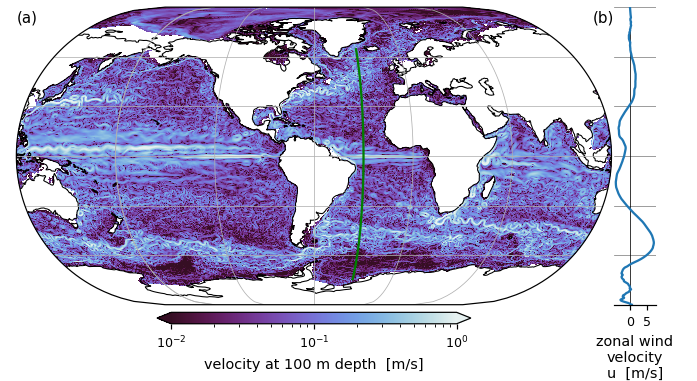

In [481]:
# # a previous version with CESM output
# ds = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)

# f = plt.figure(figsize=(6.4,3.5))

# ax = f.add_axes([0,.2,.9,.78], projection=ccrs.EckertIII(central_longitude=-60))
# ax.text(0,.95,'(a)', transform=ax.transAxes)
# im = ax.pcolormesh(ds.TLONG, ds.TLAT, np.sqrt(U**2+V**2)/1e2,
#                    norm=colors.LogNorm(vmin=0.01, vmax=1),
#                    cmap='cmo.dense_r', transform=ccrs.PlateCarree())
# ax.plot(101*[-30], np.linspace(-74.5,64.5,101), c='green', transform=ccrs.PlateCarree())
# ax.coastlines(resolution='110m', linewidth=.7)
# ax.gridlines(linewidth=.5)
# ax.set_global()

# cbax = f.add_axes([0.225,.15,.45,.03])
# plt.colorbar(im, cax=cbax, orientation='horizontal', extend='both').set_label(label='velocity at 100 m depth  [m/s]',size=9.5)

# ax = f.add_axes([.88,.2,.06,.78])
# ax.text(0,.95,'(b)', transform=ax.transAxes, ha='right')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

# ax.set_yticks([])
# ax.set_xlabel('zonal wind\nvelocity\nu  [m/s]', fontsize=9.5)
# for l in np.arange(-90,91,30):
#     ax.axhline(l, c='grey', lw=.5)
# ax.set_ylim((-90,90))
# ax.axvline(0, c='k', lw=.5)
# ax.plot(u, u.latitude)

# plt.savefig('../../results/thesis/12_windcirc')